[ 임소영 ] 의사결정트리, 부스팅

[ 피쳐-(임시) ] 단백질(g),나트륨(mg) ,당류(g), 포화지방(g)

[ 데이터셋 ] 
- 맥도날드 : https://www.kaggle.com/datasets/mcdonalds/nutrition-facts
- 롯데리아 : https://www.lotteeatz.com/upload/stg/etc/ria/items.html
- 미국 전 지점 : https://www.kaggle.com/datasets/ulrikthygepedersen/fastfood-nutrition
- 버거킹 : https://emilysinglelife.tistory.com/62
- 맘스터치(이미지) : https://www.momstouch.co.kr/m/brand/notice-view.php?idx=49
- 노브랜드 : https://realjace.tistory.com/entry/%EB%85%B8%EB%B8%8C%EB%9E%9C%EB%93%9C%EB%B2%84%EA%B1%B0-%EB%A9%94%EB%89%B4%EB%B3%84-%EC%B9%BC%EB%A1%9C%EB%A6%AC-%EC%98%81%EC%96%91%EC%84%B1%EB%B6%84-%EC%B4%9D%EC%A0%95%EB%A6%AC
- 프랭크 버거 : https://rooftoper.tistory.com/entry/%ED%94%84%EB%9E%AD%ED%81%AC-%EB%B2%84%EA%B1%B0-%EC%98%81%EC%96%91%EC%84%B1%EB%B6%84

## 자료 준비, 전처리 (결측치, 중복값, 이상치)

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [106]:
file = './Hamburger.csv'
data = pd.read_csv(file)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   restaurant  1068 non-null   object 
 1   item        1068 non-null   object 
 2   calories    1068 non-null   float64
 3   sodium      1068 non-null   float64
 4   sugar       1068 non-null   float64
 5   total_fat   1068 non-null   float64
 6   protein     1068 non-null   float64
dtypes: float64(5), object(2)
memory usage: 58.5+ KB


In [107]:
data.isna().sum()

restaurant    0
item          0
calories      0
sodium        0
sugar         0
total_fat     0
protein       0
dtype: int64

In [108]:
data.duplicated().sum()

2

In [109]:
data

,restaurant,item,calories,sodium,sugar,total_fat,protein
0,Mcdonalds,Artisan Grilled Chicken Sandwich,380.00,1110.00,11.00,7.00,37.00
1,Mcdonalds,Single Bacon Smokehouse Burger,840.00,1580.00,18.00,45.00,46.00
2,Mcdonalds,Double Bacon Smokehouse Burger,1130.00,1920.00,18.00,67.00,70.00
3,Mcdonalds,Grilled Bacon Smokehouse Chicken Sandwich,750.00,1940.00,18.00,31.00,55.00
4,Mcdonalds,Crispy Bacon Smokehouse Chicken Sandwich,920.00,1980.00,18.00,45.00,46.00
...,...,...,...,...,...,...,...
1063,prank_burger,더블치즈버거(L),687.04,4.55,33.45,19.51,1149.60
1064,prank_burger,머쉬룸버거(L),665.30,13.58,26.75,18.10,1203.43
1065,prank_burger,JG버거(L),828.28,6.42,48.23,22.28,1574.77
1066,prank_burger,SG불고기버거(L),491.06,13.84,17.24,10.60,606.15


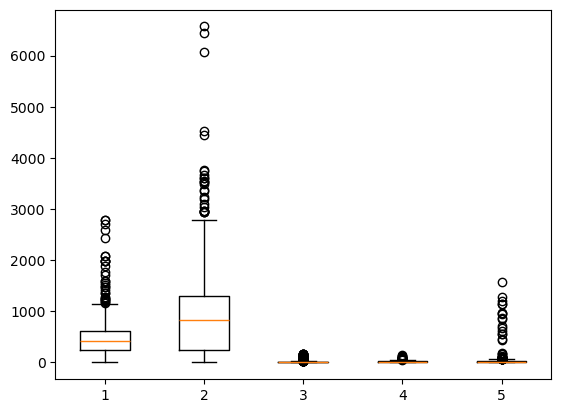

In [110]:
plt.boxplot(data[['calories','sodium','sugar','total_fat','protein']])
plt.show()

In [111]:
def print_flier(insert_data):
    q1 = insert_data.quantile(0.25)
    q3 = insert_data.quantile(0.75)
    iqr = q3 - q1
    #print(f"[ q1 ] \n{q1}\n\n[ q3 ] \n{q3}\n")
    #print(f"[ iqr의 범위 ]\n{iqr}\n")

    print('------------------ 이상값이 될 기준 계산 ------------------\n')

    lower = q1 - 1.5 * iqr
    #print(f"[ lower의 값 ]\n{lower}\n")
    upper = q3 + 1.5 * iqr
    #print(f"[ upper의 값 ]\n{upper}\n")

    mask = insert_data < lower
    print(f"[ lower의 개수 ]\n{mask.sum()}\n")
    mask2 = insert_data > upper
    print(f"[ upper의 개수 ]\n{mask2.sum()}\n")

    return lower, upper

lower, upper = print_flier(data[['calories','sodium','sugar','total_fat','protein']])

------------------ 이상값이 될 기준 계산 ------------------

[ lower의 개수 ]
calories     0
sodium       0
sugar        0
total_fat    0
protein      0
dtype: int64

[ upper의 개수 ]
calories      31
sodium        26
sugar        150
total_fat     33
protein       45
dtype: int64


In [112]:
data[['calories','sodium','sugar','total_fat','protein']].shape

(1068, 5)

In [113]:
def drop_flier(insert_data, col_name):
    global lower
    global upper
    print(f"이상치 제거 전 shape 확인: {insert_data.shape}")
    mask = insert_data[col_name] >= lower.loc[col_name]
    insert_data = insert_data[mask]
    #print(f" '{col_name}' 컬럼에서 lower 미만의 값 제거 후 shape: {insert_data.shape}")

    mask2 = insert_data[col_name] <= upper.loc[col_name]
    insert_data = insert_data[mask2]
    #print(f" '{col_name}' 컬럼에서 upper 초과의 값 제거 후 shape: {insert_data.shape}\n")
    
    print(f"이상치 제거 후 shape 확인: {insert_data.shape} \n")
    return insert_data

data_for_drop = data[['calories','sodium','sugar','total_fat','protein']]
data_for_drop = drop_flier(data_for_drop, 'calories')
data_for_drop = drop_flier(data_for_drop, 'sodium')
data_for_drop = drop_flier(data_for_drop, 'sugar')
data_for_drop = drop_flier(data_for_drop, 'total_fat')
data_for_drop = drop_flier(data_for_drop, 'protein')

data_for_drop.shape

이상치 제거 전 shape 확인: (1068, 5)
이상치 제거 후 shape 확인: (1037, 5) 

이상치 제거 전 shape 확인: (1037, 5)
이상치 제거 후 shape 확인: (1027, 5) 

이상치 제거 전 shape 확인: (1027, 5)
이상치 제거 후 shape 확인: (886, 5) 

이상치 제거 전 shape 확인: (886, 5)
이상치 제거 후 shape 확인: (868, 5) 

이상치 제거 전 shape 확인: (868, 5)
이상치 제거 후 shape 확인: (851, 5) 


(851, 5)

In [114]:
len(list(data_for_drop.index))

851

In [115]:
len(list(data.index))

1068

In [116]:
# 이상치 제거한 데이터에 맞게 원본 데이터도 제거된 인덱스 번호를 같이 drop 시켜줌
for i in list(data.index):
    if i not in (list(data_for_drop.index)):
        data.drop(i,inplace = True)
print(data.shape)

(851, 7)


In [117]:
# 인덱스 번호가 서로 일치하는지 확인
print(len(list(data_for_drop.index)) == len(list(data.index)))
# 서로 일치하는 것을 확인 했으니 이 데이터를 이용해서 알고리즘 돌리겠다.

True


In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851 entries, 0 to 1050
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   restaurant  851 non-null    object 
 1   item        851 non-null    object 
 2   calories    851 non-null    float64
 3   sodium      851 non-null    float64
 4   sugar       851 non-null    float64
 5   total_fat   851 non-null    float64
 6   protein     851 non-null    float64
dtypes: float64(5), object(2)
memory usage: 53.2+ KB


In [119]:
data.corr(numeric_only=True)
#??뭐지?? 왜 나트륨이 가장 상관관계가 높지? 나트륨은 칼로리가 없는 것으로 확인되는데?

,calories,sodium,sugar,total_fat,protein
calories,1.000000,0.857458,0.280034,0.792475,0.837067
sodium,0.857458,1.000000,0.160648,0.742896,0.827102
sugar,0.280034,0.160648,1.000000,0.099064,0.204924
total_fat,0.792475,0.742896,0.099064,1.000000,0.665665
protein,0.837067,0.827102,0.204924,0.665665,1.000000


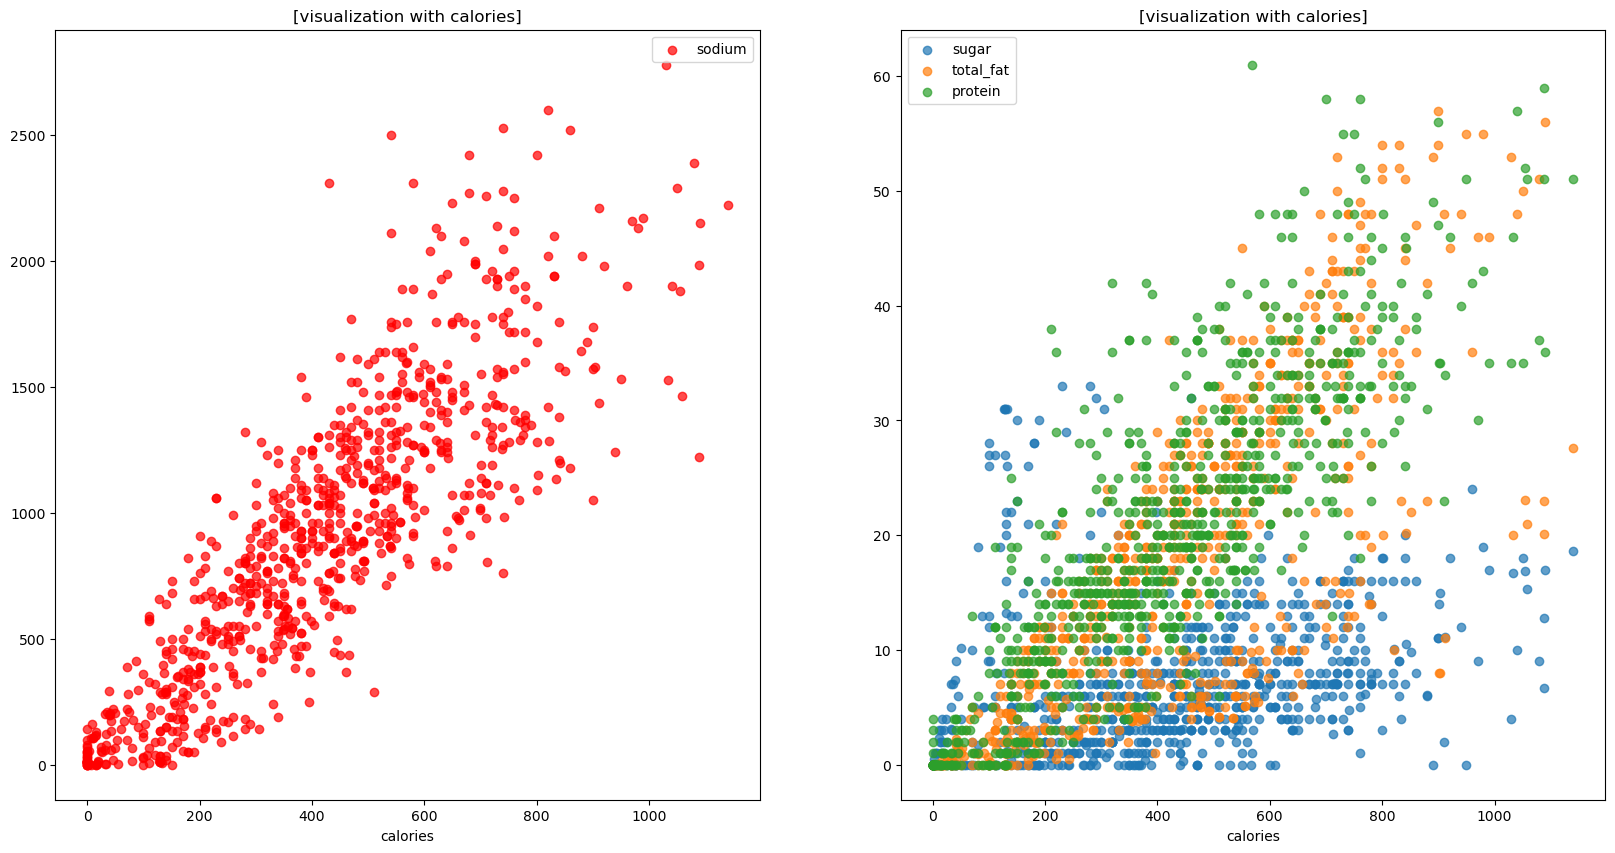

In [120]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(data['calories'], data['sodium'], label = 'sodium', c = 'red', alpha = 0.7)
plt.legend(loc = 'best')
plt.xlabel('calories')
plt.title("[visualization with calories]")

plt.subplot(1,2,2)
plt.scatter(data['calories'], data['sugar'], label = 'sugar', alpha = 0.7)
plt.scatter(data['calories'], data['total_fat'], label = 'total_fat', alpha = 0.7)
plt.scatter(data['calories'], data['protein'], label = 'protein', alpha = 0.7)
plt.legend(loc = 'best')
plt.xlabel('calories')
plt.title("[visualization with calories]")
plt.show()

## 데이터셋 분리

In [121]:
target = data['calories']
feature = data[['sodium','sugar','total_fat','protein']]

In [122]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, random_state = 7)

print(f"[훈련용] X_train : {X_train.shape}   y_train : {y_train.shape}")
print(f"[테스트용] X_test : {y_test.shape}   y_test : {y_test.shape}")

[훈련용] X_train : (638, 4)   y_train : (638,)
[테스트용] X_test : (213,)   y_test : (213,)


## 스케일링

In [123]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [124]:
X_train = pd.DataFrame(scaled_X_train, columns = ['sodium', 'sugar', 'total_fat', 'protein'])
X_test = pd.DataFrame(scaled_X_test, columns = ['sodium', 'sugar', 'total_fat', 'protein'])

In [125]:
# 스케일링이 잘 되었는지 확인해보자
"""
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(y_train, X_train['sodium'], label = 'sodium', alpha = 0.5)
plt.scatter(y_train, X_train['sugar'], label = 'sugar', alpha = 0.5)
plt.scatter(y_train, X_train['total_fat'], label = 'total_fat', alpha = 0.5)
plt.scatter(y_train, X_train['protein'], label = 'protein', alpha = 0.5)
plt.legend(loc = 'best')
plt.title('preprocessing with STD scaler - TRAIN')

plt.subplot(1,2,2)
plt.scatter(y_test, X_test['sodium'], label = 'sodium', alpha = 0.5)
plt.scatter(y_test, X_test['sugar'], label = 'sugar', alpha = 0.5)
plt.scatter(y_test, X_test['total_fat'], label = 'total_fat', alpha = 0.5)
plt.scatter(y_test, X_test['protein'], label = 'protein', alpha = 0.5)
plt.legend(loc = 'best')
plt.title('preprocessing with STD scaler - TEST')

plt.tight_layout
plt.show()
"""

# 스케일링이 잘된 것을 확인했다

"\nplt.figure(figsize=(14,6))\nplt.subplot(1,2,1)\nplt.scatter(y_train, X_train['sodium'], label = 'sodium', alpha = 0.5)\nplt.scatter(y_train, X_train['sugar'], label = 'sugar', alpha = 0.5)\nplt.scatter(y_train, X_train['total_fat'], label = 'total_fat', alpha = 0.5)\nplt.scatter(y_train, X_train['protein'], label = 'protein', alpha = 0.5)\nplt.legend(loc = 'best')\nplt.title('preprocessing with STD scaler - TRAIN')\n\nplt.subplot(1,2,2)\nplt.scatter(y_test, X_test['sodium'], label = 'sodium', alpha = 0.5)\nplt.scatter(y_test, X_test['sugar'], label = 'sugar', alpha = 0.5)\nplt.scatter(y_test, X_test['total_fat'], label = 'total_fat', alpha = 0.5)\nplt.scatter(y_test, X_test['protein'], label = 'protein', alpha = 0.5)\nplt.legend(loc = 'best')\nplt.title('preprocessing with STD scaler - TEST')\n\nplt.tight_layout\nplt.show()\n"

## 학습 및 평가

In [126]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [127]:
model = AdaBoostRegressor()
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"[train score] {train_score}      [test_score] {test_score}")

[train score] 0.8554740811277919      [test_score] 0.7958479174951835


In [128]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"[train score] {train_score}  [test_score] {test_score}")

[train score] 0.9377123733361034  [test_score] 0.8600587584286155


In [129]:
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"[train score] {train_score}  [test_score] {test_score}")

[train score] 0.9597624054830891  [test_score] 0.8501217074671608


- GradientBoostingRegressor가 가장 점수 차이가 적기 때문에 이 모델로 채택했다.
- 또한 과대적합이 발생하여 튜닝을 실시했다

## 튜닝 : 파라미터 조정

In [102]:
from sklearn.model_selection import GridSearchCV

In [136]:
GBR_model = GradientBoostingRegressor()

param = {'max_depth' : [1,2,3,4,5,6,7,8,9],
        'n_estimators' : [1, 2, 3, 4, 5],
        'learning_rate' : [1, 2, 3, 4, 5],
        'min_samples_leaf' : [1, 2, 3, 4, 5]
         }
        
cv_num = 5

gs = GridSearchCV(GBR_model, param_grid = param, cv = cv_num, return_train_score = True)

result = gs.fit(X_train, y_train)

resultDF = pd.DataFrame(gs.cv_results_)

print(f"max train score : {max(resultDF['mean_train_score'])}")
print(f"max test score : {max(resultDF['mean_test_score'])}\n")

# 최고 성능의 파라미터, 최고의 점수
print(f"best parameters : {gs.best_params_}")
print(f"best score : {gs.best_score_}")

max train score : 0.9996928783498508
max test score : 0.8056250830289112

best parameters : {'learning_rate': 1, 'max_depth': 4, 'n_estimators': 2}
best score : 0.8056250830289112


In [96]:
# total_model = gs.best_estimator_

## 예측

In [130]:
# y_pred = total_model.predict(X_test)
# y_pred

## 성능 평가

In [131]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [132]:
# print(f"R2 SCORE : {r2_score(y_test, y_pred)}")
# print(f"MSE : {mean_squared_error(y_test, y_pred)}")
# print(f"MAE : {mean_absolute_error(y_test, y_pred)}")

## 모델 저장

In [133]:
import joblib
import os

In [134]:
model_dir = './YSY_model/'